In [10]:
import numpy as np 
import pandas as pd 
from reduced_form_models import * 

from time import time 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score

import tensorflow as tf  

# from keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from Neural_network_utils import ParamGenerator

import matplotlib.pyplot as plt

In [2]:
def NN_generator(InputShape, out_shape, nLayers, nNodes, activationFun='relu', loss='mse', optimizer='rmsprop', LR=0.001, lr_scheduler=None, BatchNorm=0, show=1):
    
    # First Layer : Input Layer
    input_layer = Input(shape=(InputShape, ))
    
    # Defining the first hidden layer
    x = Dense(nNodes, activation=activationFun)(input_layer)
    
    if BatchNorm==1:
        
        x = BatchNormalization()(x)
    
    # adding more layers
    
    i = 1
    
    while i<nLayers:
        
        x = Dense(nNodes, activation=activationFun)(x)
        if BatchNorm==1:
            x = BatchNormalization()(x)
        i+=1
    
    # adding the last layer
    x = Dense(out_shape, activation='linear')(x)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    
    # # Compiling the model 
    
    # Configuring the optimizer with the specified learning rate
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=LR)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=LR)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=LR)
    else:
        raise ValueError("Unsupported optimizer. Choose 'rmsprop', 'adam', or 'sgd'.")
    
    # Compiling the model
    model.compile(loss=loss, optimizer=opt)
    
    # ## Different Optimizers are compared in companion notebook
    # model.compile(loss=loss, optimizer=optimizer)
    
    if show==1:
        print(model.summary())
        
    return model

def price_generator(data):
    
    result = np.empty((len(data), 2))
        
    for i in range(0, len(data)):
        
        T = data[i,0] # bond maturity        
        r = data[i,1] # risk free-rate
        P = np.exp(-r*T) # risk-free discoutn factor  
        rec_rate = data[i,2] # recovery rate 
        x0 = data[i,3] # risky factor
        k0 = data[i, 4] # speed of mean reversion first factor 
        theta0 = data[i, 5] # long run mean 
        sigma0 = data[i, 6] # vol

        beta1 = data[i, 7] 
        x1 = data[i,8] # risky factor
        alpha1 = data[i, 9] # speed of mean reversion first factor 
        lam1 = data[i, 10] # long run mean 
        eta1 = data[i, 11] # vol
        
        # c = data[i, 12] # coupon rate
        rZCB = risky_zcb13(k0, theta0, sigma0, x0, x1, alpha1, lam1, eta1, beta1, T, P, rec_rate)
        # rZCB = risky_cb13(x0, k0, theta0, sigma0, beta1, x1, alpha1, lam1, eta1, maturities, P, c, rec_rate) # risky zcb
        s = -np.log(rZCB)/T - r # risky spread 
        
        result[i,0] = s 
        result[i, 1] = rZCB
    
    result = np.hstack((data, result))
    
    columns = ['T', 'r', 'rec_rate', 'x0', 'k0', 'theta0', 'sigma0', 'beta1', 'x1', 'k1', 'theta1', 'sigma1', 'spread', 'rZCB']
    
    result = pd.DataFrame(result, columns=columns)    
    
    return result

In [3]:
np.random.seed(42)

n = int(1e5)

T_lb = 1 
T_ub = 30

r_lb = -0.01
r_ub = .05 

x0_lb = 0 
x0_ub = 1 

rec_rate_lb = 0 
rec_rate_ub = 1

k_lb = 1e-1 
k_ub = 2 

theta_lb = 1e-4
theta_ub = .35 

sigma_lb = 1e-4
sigma_ub = 1 

c_lb = .005
c_ub = .125

beta_lb = 0.001
beta_ub = 2

alpha_lb = 1e-2
alpha_ub = 10 

lam_lb = 1e-3 
lam_ub = 1.5

eta_lb = 1e-3 
eta_ub = .5

lb = np.array([T_lb, r_lb, rec_rate_lb, x0_lb, k_lb, theta_lb, sigma_lb, beta_lb, x0_lb, alpha_lb, lam_lb, eta_lb])
ub = np.array([T_ub, r_ub, rec_rate_ub, x0_ub, k_ub, theta_ub, sigma_ub, beta_ub, x0_ub, alpha_ub, lam_ub, eta_ub])

data = ParamGenerator(n, len(lb), lb, ub)

start = time() 

dataset = price_generator(data)

end = time() 

elapsed_time = end-start

print(f"Elapsed time: {elapsed_time}")

Elapsed time: 41.84080672264099


In [4]:
# Testing for a pricing NN 

X = dataset.loc[:, ['T', 'r', 'spread']]
Y = dataset.loc[:, ['rZCB']] 

X = X.values
Y = Y.values 

q = np.quantile(Y, .99) 

Y1 = Y[Y<q]

X1 = []

for i,y in enumerate(Y): 
    if y[0]<q:
        X1.append(X[i])

X1 = np.array(X1)

x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)


In [6]:
# Constructing the neural network
nNodes = 500
nLayers = 4
InputShape = len(X[0])
outShape= 1
BatchSize = 32
nEpochs = 80

model1 = NN_generator(InputShape, outShape, nLayers, nNodes, 'relu','mse','adam')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 500)               2000      
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 1)                 501       
                                                                 
Total params: 754,001
Trainable params: 754,001
Non-trainable

In [7]:
# Training the model 

start = time()
    
result = model1.fit(x_train, y_train, epochs=nEpochs, batch_size=BatchSize, validation_split = 0.25, verbose = 0)

end = time()

print('Elapsed time : ' + str(end-start))

Elapsed time : 606.7894876003265


In [8]:
predictions = model1.predict(x_test)

r2 = r2_score(y_test, predictions)

print(f"R² score: {r2}")

774/774 [==============================] - 2s 2ms/step
R² score: 0.9999727861180544


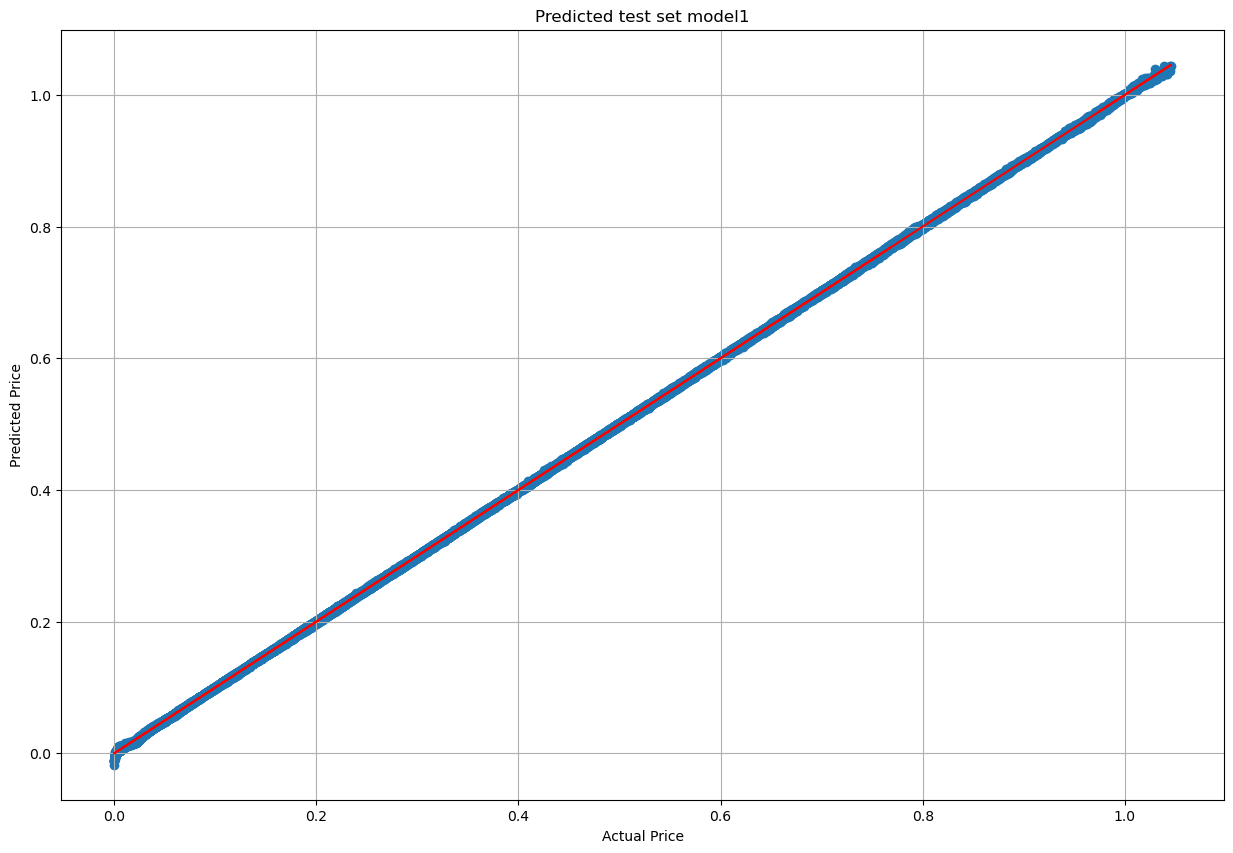

In [11]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot(y_test, y_test, 'r')
plt.grid(True)
plt.title('Predicted test set model1')
plt.show()

In [12]:
# Extract loss values
train_loss = result.history['loss']
val_loss = result.history['val_loss']

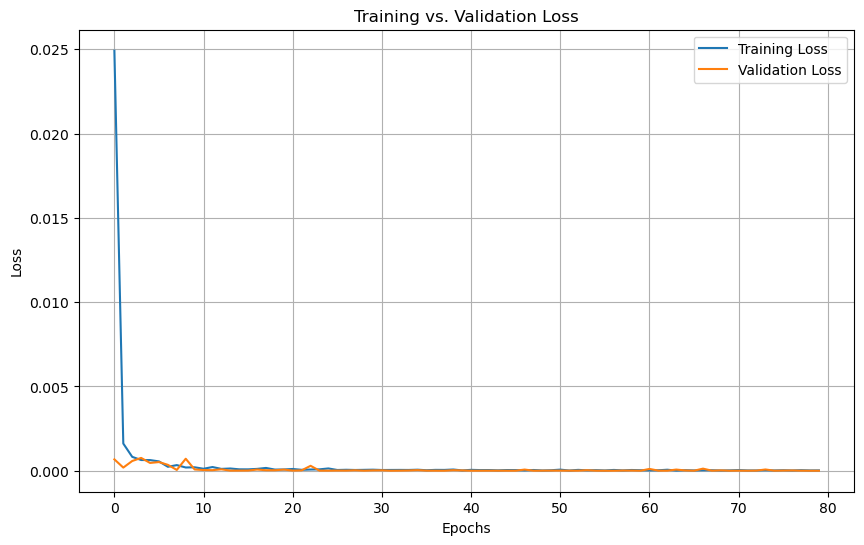

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()